In [1]:
# Add description here
#
# *Note:* You can open this file as a notebook (JupyterLab: right-click on it in the side bar -> Open With -> Notebook)

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
# %load_ext autoreload
# %autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

In [3]:
# If this task has dependencies, declare them in the YAML spec and leave this
# as None
import re
from pathlib import Path
from pprint import pprint

import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, Lasso, BayesianRidge, ARDRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sktime.forecasting.model_selection import ExpandingWindowSplitter

from hydro_timeseries.plotting import plot_fea_importance, get_windows
from hydro_timeseries.util import load_timeseries_csv, smape, rmse, IdentityTransformer, select_kbest_features, \
    get_sample_weights
from hydro_timeseries.variables import Variables
import seaborn as sns
from collections import defaultdict


upstream = None

# This is a placeholder, leave it as None
product = None

def read_auto_features(path: str) -> pd.DataFrame:
    auto_features = pd.read_csv(path, parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
    auto_features.index = pd.to_datetime(auto_features.index)
    auto_features.index = auto_features.index.tz_localize(tz=None)
    return auto_features

In [4]:
# Parameters
random_seed = 1
valid_from = "2021-11-01"
auto_meteo_features = "../features_minute.csv"
auto_value_features = "../features_daily_value.csv"
auto_meteo_daily_features = "../features_daily.csv"
daily_discount_rate = 0.005
plots_path = "../plots"
upstream = {"run-tests": {"nb": "../run_tests.ipynb", "data": "../data/feature_manual.csv"}}
product = {"nb": "../exploratory_auto.ipynb"}


In [5]:
'''
Add detrended target
- include daily mean of the detrended target lagged by two days. 
detrenders = ['arima_current', 'ets', 'exp', 'stl']
'''
# max_selected_features = 50
detrender = 'arima_current'
target_new = 'value_detr'
features = load_timeseries_csv(upstream['feature-manual']['data'])
value_detr = (features['Value'] - features[detrender]).dropna()
features = features.assign(value_detr = value_detr)

features['value_detr_daily_lag2'] = features[target_new].resample('D').mean().dropna().shift(2)
features['value_detr_daily_lag2'] = features['value_detr_daily_lag2'].ffill()

plots_path = Path(plots_path)

In [6]:
features_meteo = read_auto_features(auto_meteo_features)
# features_meteo = pd.read_csv(auto_meteo_features, parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
# features_meteo.index = pd.to_datetime(features_meteo.index)
# features_meteo.index = features_meteo.index.tz_localize(tz = None)


soil_moisture = features_meteo.filter(regex='.*moisture.*')
precip = features_meteo.filter(regex='.*precip.*')
pressure = features_meteo.filter(regex='.*pressure.*')
snow = features_meteo.filter(regex='.*snow.*')
transpiration = features_meteo.filter(regex='.*transpiration.*')
del features_meteo

soil_moisture_cols = soil_moisture.columns.to_list()
precip_cols = precip.columns.to_list()
pressure_cols = pressure.columns.to_list()
snow_cols = snow.columns.to_list()
transpiration_cols = transpiration.columns.to_list()

In [7]:
features_value_auto = read_auto_features(auto_value_features)
value_cols = features_value_auto.columns.to_list()

In [8]:
features_concat = pd.concat([features, features_value_auto, soil_moisture, precip, pressure, snow, transpiration], axis=1)
features_new = features_concat[~features_concat['value_detr_daily_lag2'].isna() * ~features_concat['value_detr'].isna()]
features_new = features_new.dropna(axis = 1)
# features_concat = features_concat.loc[~(features_concat['Value'] == 0), :]

del features_value_auto

In [9]:
'''
feature_cols = value_cols + \
               snow_cols + \
               transpiration_cols + \
               pressure_cols + \
               precip_cols + \
               soil_moisture_cols + \
               Variables.cyclical_sin + \
               Variables.stl + \
               Variables.lagged + \
               Variables.meteo_ewms_hourly + \
               ['value_detr_daily_lag2']

'''

feature_cols = value_cols + \
               snow_cols + \
               transpiration_cols + \
               pressure_cols + \
               precip_cols + \
               soil_moisture_cols + \
               Variables.cyclical_sin + \
               Variables.stl + \
               Variables.meteo_ewms_hourly + \
               Variables.meteo_i + \
               ['value_detr_daily_lag2']

In [10]:
features_train = features_new.iloc[:int(len(features_new) * 0.7)]

In [11]:

# initial = Pipeline([
#          ('scaler', StandardScaler()),
#          ('selector', SelectFromModel(Lasso(alpha=0.1, max_iter=10000, tol=1e-3))),
#          ('regressor', BayesianRidge(n_iter=10000))
# ])

var_selector_model = Lasso(normalize=True, alpha=0.2, tol=1e-4)


weights = get_sample_weights(features_train, daily_discount_rate)

var_selector_model.fit(features_train[feature_cols], features_train[target_new])
var_selector_model = var_selector_model.fit(features_train[feature_cols], features_train[target_new],sample_weight=weights)
var_selector = SelectFromModel(var_selector_model, prefit=True)
features_train_selected = var_selector.transform(features_train[feature_cols])

selected_vars_ = features_train[feature_cols].columns[var_selector.get_support()].to_list()
pprint(selected_vars_)


# selected_vars = ['val_sh2__agg_linear_trend__attr_rvalue__chunk_len_5__f_agg_min',
#  'evapotranspiration_mean__quantile__q_01',
#  'evapotranspiration_mean__variation_coefficient',
#  'evapotranspiration_mean__permutation_entropy__dimension_6__tau_1',
#  'pressure_mean__benford_correlation',
#  'precip_mean__quantile__q_04',
#  'soil_moisture_index_104',
#  'soil_moisture_index_134',
#  'daily_mean_precip_104_lag1',
#  'daily_mean_precip_104_lag2',
# ]

# ['val_sh2__agg_linear_trend__attr_rvalue__chunk_len_5__f_agg_min',
#  'val_sh2__linear_trend__attr_pvalue',
#  'snow_mean__spkt_welch_density__coeff_2',
#  'evapotranspiration_mean__quantile__q_01',
#  'evapotranspiration_mean__variation_coefficient',
#  'evapotranspiration_mean__permutation_entropy__dimension_6__tau_1',
#  'pressure_mean__benford_correlation',
#  'precip_mean__quantile__q_04',
#  'precip_mean__change_quantiles__f_agg_var__isabs_True__qh_04__ql_02',
#  'soil_moisture_mean__change_quantiles__f_agg_var__isabs_False__qh_08__ql_02',
#  'soil_moisture_mean__ar_coefficient__coeff_6__k_10']



['val_sh2__agg_linear_trend__attr_rvalue__chunk_len_5__f_agg_min',
 'val_sh2__linear_trend__attr_pvalue',
 'val_sh2__agg_linear_trend__attr_slope__chunk_len_5__f_agg_min',
 'snow_mean__spkt_welch_density__coeff_2',
 'snow_mean__variance',
 'snow_mean__agg_linear_trend__attr_stderr__chunk_len_50__f_agg_var',
 'snow_mean__large_standard_deviation__r_04',
 'snow_mean__has_duplicate',
 'evapotranspiration_mean__quantile__q_01',
 'evapotranspiration_mean__sum_of_reoccurring_data_points',
 'evapotranspiration_mean__variation_coefficient',
 'evapotranspiration_mean__approximate_entropy__m_2__r_01',
 'evapotranspiration_mean__spkt_welch_density__coeff_8',
 'evapotranspiration_mean__permutation_entropy__dimension_6__tau_1',
 'evapotranspiration_mean__fft_coefficient__attr_real__coeff_18',
 'evapotranspiration_mean__variance',
 'evapotranspiration_mean__change_quantiles__f_agg_mean__isabs_False__qh_06__ql_02',
 'evapotranspiration_mean__fft_coefficient__attr_real__coeff_19',
 'pressure_mean__cha

/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/m/miniconda3/envs/hydro-power-prediction/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


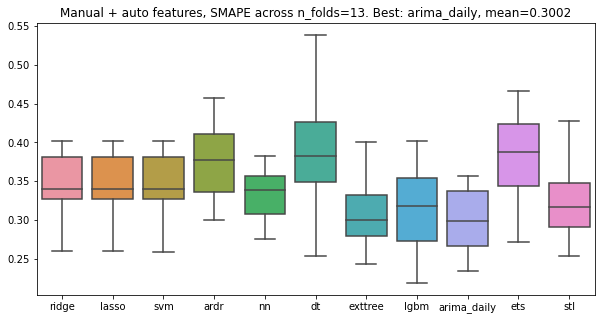

ridge          0.342237
lasso          0.342359
svm            0.342259
ardr           0.375830
nn             0.332394
dt             0.389395
exttree        0.307783
lgbm           0.315048
arima_daily    0.300241
ets            0.379974
stl            0.324695
dtype: float64


In [12]:
'''
Rolling weekly cross val - monthly test set
'''

selected_vars = [
 'stl_seasonal_lag2',
 'soil_moisture_index_75',
 'soil_moisture_index_104',
 'soil_moisture_index_134',
 'daily_mean_precip_104_lag1',
 'daily_mean_precip_104_lag2',
 'daily_mean_Value_lag2',
 'soil_moisture_mean__ar_coefficient__coeff_3__k_10',
 'snow_mean__large_standard_deviation__r_04',
 'val_sh2__agg_linear_trend__attr_rvalue__chunk_len_5__f_agg_min'
 # 'precip_mean__median',
 # 'snow_mean__variance',
 # 'val_sh2__linear_trend__attr_pvalue',
 # 'val_sh2__agg_linear_trend__attr_rvalue__chunk_len_5__f_agg_min',
 # 'evapotranspiration_mean__variation_coefficient',
 # 'soil_moisture_mean__ar_coefficient__coeff_6__k_10',
 # 'pressure_mean__benford_correlation'
]

monthly = 96*30
weekly = 96*7
fh_monthly = list(range(1, monthly))

X_all = features_new[[target_new] + selected_vars].dropna()
cv = ExpandingWindowSplitter(initial_window=int(len(X_all) * 0.7), step_length=weekly, fh=fh_monthly)
train_windows, test_windows = get_windows(X_all, cv)


models = {
    'ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', BayesianRidge(n_iter=3000))]),
    'lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LassoCV(alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1], max_iter=10000))
    ]),

    'svm': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearSVR(C=2.0, loss = 'squared_epsilon_insensitive', max_iter=10000))
    ]),
    'ardr': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', ARDRegression(n_iter=3000))
    ]),
    'nn': Pipeline([
        ('scaler', StandardScaler()),
        ('selector', PCA(n_components=4)),
        ('regressor', MLPRegressor(hidden_layer_sizes=(32), alpha=5.0, early_stopping=True, learning_rate='adaptive'))]),

    'dt': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', DecisionTreeRegressor(max_depth = 15, random_state=random_seed))]),
    'exttree': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', ExtraTreesRegressor(n_estimators=30, max_depth=15, random_state=random_seed))]),
    'lgbm': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LGBMRegressor(n_estimators=30, max_depth=15, random_state=random_seed))]),
}

smapes = defaultdict(list)

for fold_id, (train_ids, test_ids) in enumerate(cv.split(X_all)):
    X_train = X_all.iloc[train_ids][selected_vars]
    X_test = X_all.iloc[test_ids][selected_vars]
    y_train = X_all.iloc[train_ids][target_new]
    y_test = X_all.iloc[test_ids][target_new]

    sample_weights = get_sample_weights(X_train, daily_discount_rate)

    for key in models:
        model = models[key]

        if key == 'nn' or key == 'ardr' or key == 'gp':
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train, regressor__sample_weight=sample_weights)

        y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=[target_new])

        # here to prevent column warning from sktime
        value_pred = pd.DataFrame(features_new.loc[X_test.index][detrender] + y_pred[target_new], index=X_test.index, columns=['Value'])
        value_true = features_new.loc[y_pred.index]['Value']

        if not (value_pred.index == value_true.index).all():
            print("break")

        smapes[key].append(smape(value_true, value_pred))

    # add detrenders arima, autoets, stl for comparison
    value_pred = features_new.loc[X_test.index]['arima_current']
    value_true = features_new.loc[X_test.index]['Value']
    smapes['arima_daily'].append(smape(value_true, value_pred))

    value_pred = features_new.loc[X_test.index]['ets']
    smapes['ets'].append(smape(value_true, value_pred))

    value_pred = features_new.loc[X_test.index]['stl']
    smapes['stl'].append(smape(value_true, value_pred))

smapes = pd.DataFrame().from_dict(smapes)
best_model = np.mean(smapes).idxmin()

plt.figure(figsize=(10,5))
sns.boxplot(data = smapes)
ax = plt.gca()
ax.set_title(f'Manual + auto features, SMAPE across n_folds={len(train_windows)}. Best: {best_model}, mean={np.mean(smapes[best_model]):.4f}')
plt.savefig(plots_path / 'cv_auto.png')
plt.show()

print(np.mean(smapes))